### Data science Internship 
#### Task 1 : Creation of a search engine for residential complexes
#### Prepared by: Assylnur Lesken

In [1]:
#Import libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns


# For scraping
import time
from selenium import webdriver
import webbrowser
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.common.action_chains import ActionChains
from selenium.common.exceptions import NoSuchElementException
import requests


from pdfminer.pdfparser import PDFParser
from pdfminer.pdfdocument import PDFDocument
from pdfminer.pdfpage import PDFPage
import pdfminer.high_level

# NLP and EDA
import re
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import nltk
import pymorphy2

import itertools as it
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from wordcloud import WordCloud

# Search engine
import math
import h3 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

## 1. Web Scraping

I will collect data from the site https://bi.group/ru/filter, the goal is to download electronic booklets for each residential complex. 

In [4]:
driver = webdriver.Chrome(ChromeDriverManager().install())
driver.get('https://bi.group/ru/filter')

When we initially enter the website, only the first 9 residential complexes are accessible, thus we must click the "Показать eще" button to view the other complexes:

In [5]:
# Показать еще
from selenium.common.exceptions import NoSuchElementException
driver.execute_script("document.body.style.transform='scale(.02)';")
while(True):
    try:
        more = driver.find_element(by=By.CLASS_NAME,value="MRE-jss79")
        more.click()
        time.sleep(3)
    except Exception as e:
        break

We will go to each complex's site once every residential complex has been seen. To do this, using the find_element() function, we will find the location of the «Смотреть проект» buttons for each complex. 

After that, each complex's " Смoтрeть прoeкт "  button will be clicked separately. When this button was clicked by the driver, the browser opens a new window, so I use the switch_to.window() function to switch to the new window. On the page of each residential complex, the driver will first find the button for e-booklet and get the links to each e-booklet, then save the links in the new list.

Additionally, a new list will be created to contain the names of each complex; we will use this list later:

In [6]:
# find links of PDF

names = driver.find_elements(by=By.CLASS_NAME,value="header-title")
names = [i.text for i in names]
divs = driver.find_elements(by=By.CLASS_NAME,value="info-wrapper-subheader")
buttons = driver.find_elements(by=By.CLASS_NAME,value="MRE-MuiButton-outlined")

comp_names = []
pdfs = []

for button in buttons:
    time.sleep(5)
    
    i = buttons.index(button)
    div = divs[i]
    
    driver.execute_script("document.body.style.transform='scale(.02)';")
    ActionChains(driver).move_to_element(div).click(button).perform()
    
    time.sleep(5)
    
    tab1 = driver.window_handles[0]
    tab2 = driver.window_handles[-1]
    driver.switch_to.window(tab2)
    
    time.sleep(2)
    try:
        pdf_btn = driver.find_element(by=By.CSS_SELECTOR,value="a[href*='.pdf']")   

    except NoSuchElementException as e:
        pdf_btn = driver.find_element(by=By.CSS_SELECTOR,value="a[href*='.PDF']") 
#         print(i, names[i], type(e))

        
#     print(i, names[i], pdf_btn.get_attribute('href'))
    pdfs.append(pdf_btn.get_attribute('href')) 
    comp_names.append(names[i])
    

    driver.switch_to.window(tab1)

The next step is to dowload the pdfs using the links that I scraped. For this I used the pdfminer.high_level library. 

In [7]:
import urllib.request

def download_file(download_url, filename, c_name):

    try:
        response = urllib.request.urlopen(download_url)    
        c_names.append(c_name)
    except urllib.error.URLError as e:
#         print(download_url, 'not downloaded')
        return  
    
    file = open(filename, 'wb')
    pdf_name.append(filename)
    file.write(response.read())
    file.close()

In [8]:
c_names = [] #stores object names
pdf_name =[] #stores path of pdf file
for i in pdf_s:
#     print(i)
    download_file(i, './pdf/'+i.split('/')[-1].replace('.','_') , comp_names[pdfs.index(i)])

After downloading, I counted the pdf file's pages to see how many there were, and then I extracted the text from each page separately. Pages like cодеражние, ипотека, покупка, адрес, etc. are included in all of these pdfs but are not necessary for our analysis; thus I remove the text from these pages. 

Once the words had been successfully recovered, I used the re library to get rid of unnecessary characters like "\n", "\t", "\1",  and "\2",  among others, and I found the names of the cities where the complex is located.

In [9]:
# the function returns number of pages of pdf
def number_of_pages(filename):
    fp = open(filename, 'rb')
    parser = PDFParser(fp)
    document = PDFDocument(parser)
    count = 0
    for page in PDFPage.create_pages(document):
        count += 1
    fp.close()
    return count

# the function returns text of pdf and city of object
def get_text(pdfname):   
    my_dict = {};
    num_pages = number_of_pages(pdfname)

    for i in range(num_pages):
        text = pdfminer.high_level.extract_text(pdfname, page_numbers = [i])
        my_dict[i] = text.lower()

    for i, t in my_dict.items():
        if i == 0:
            my_dict[i] = t

        if 'планировки*' in t or 'онлайн покупка'in t or i == 1 or i == len(my_dict)-1:
            my_dict[i] = '' 
            
# list txt stores text of pdf file
    txt = [re.split('[^а-яА-Я-]',i.lower()) for i in list(my_dict.values())[1:] ]
    txt = [' '.join([j for j in i if j!='']) for i in txt ]
    txt = str(txt).replace("'", "").replace(", ", " ").replace('[', '').replace(']','').replace('- ','')

# list city stores city of each object
    city = [re.split('[^a-z-]',i.lower().replace('\n','')) for i in list(my_dict.values())[0] ]
    city = [' '.join([j for j in i if j!=' ']) for i in city ]
    city = [i for i in ''.join(city).split(' ') if i!='']
    city.append(' ')
    city = city[0]
    return [txt, city]

Finally, I created a CSV (Comma Separated Values) file with all the scraped data (data1). 

In total, 44 pdf files were downloaded from the website, from the cities of Nur-Sultan, Almaty, Shymkent, and Aktau.

In [10]:
# Save to CSV
df = pd.DataFrame()
df['complex'] = c_names
df['text'] = [get_text(i)[0] for i in pdf_name]
df['city'] = [get_text(i)[1] for i in pdf_name]

df.to_csv('data1.csv')
display(df)

,complex,text,city
0,4YOU,генеральный план очередь продажа очередь прод...,almaty
1,Akbulak Riviera,о проекте это эксклюзивный проект от в самом ...,nur-sultan
2,Aktau Riviera,о проекте наслаждайтесь морским побережьем эт...,aktau
3,ALA Park,о проекте это проект комфорт-класса в котором...,almaty
4,Al-Farabi,о проекте удачное расположение в новом культу...,shymkent
5,Altair,о проекте в новом жк нашли отражение восточны...,shymkent
6,AMIR,о проекте жк это проект бизнес и бизнес класс...,almaty
7,Arman Qala,о стандарт класс новое видение будущего для ж...,shymkent
8,Atlant,о проекте это современный жилой квартал котор...,nur-sultan
9,Aulet,о проекте жилой комплекс это дом семейных цен...,almaty


In [11]:
df.shape

(44, 3)

## 2. Text analysis, EDA

I’ll use nltk library for Text analysis and EDA. It is a library for advanced Natural Language Processing in Python. The words are first tokenized using the word_tokenize() function, and all of the tokens are then stored in a single list. Then, I'll utilize the nltk and pymorphy2 libraries in the next section to lemmatize and eliminate stop words.

In [12]:
# tokenize the words and save all words to one list
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk
import itertools as it
words = list()
for txt in df['text']:
    element = word_tokenize(txt, language="russian")
    words.append(element)
words = list(it.chain(*words))

len(words) 

47202

In [13]:
# Lemmatization 
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
tokens = [morph.parse(i)[0].normal_form if morph.parse(i)[0].normal_form[0]!='-' 
          else morph.parse(i)[0].normal_form[1:] for i in words]

Let's examine the distribution of the top bigrams and trigrams before removing the stop words. 

<i>An n-gram is a contiguous sequence of n items from a given sample of text or speech. Different definitions of n-grams will allow for the identification of the most prevalent words/sentences in the data.</i>

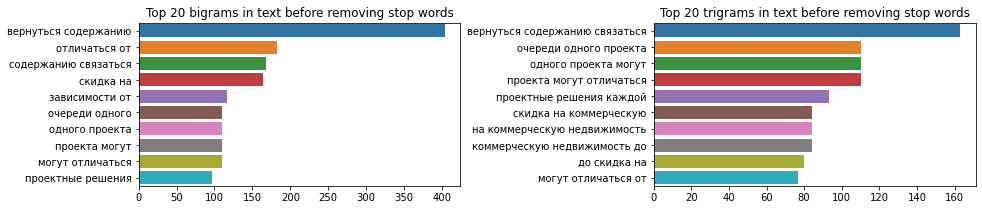

In [14]:
# Function returns n-grams
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]


# Top bigrams before removing stop words
top_n_trigrams=get_top_ngram(df['text'],3)[:20]
x2,y2=map(list,zip(*top_n_trigrams)) 

# Top trigrams before removing stop words
top_n_bigrams=get_top_ngram(df['text'],2)[:20] 
x,y=map(list,zip(*top_n_bigrams)) 

# Plot
fig, ax= plt.subplots(ncols=2,figsize=(15,3))
fig.subplots_adjust( wspace=0.6)
ax[0].set_title('Top 20 bigrams in text before removing stop words')
sns.barplot(x=y,y=x, ax=ax[0]);
ax[1].set_title('Top 20 trigrams in text before removing stop words')
sns.barplot(x=y2,y=x2, ax=ax[1]);

From the n-grams it can be seen that many of these trigrams are some combinations of bigrams such as “очереди одного” and “одного проекта”. It means that we should put some effort into data cleaning and see if we were able to combine those synonym terms into one clean token.
<br><br><br>


To remove stop words I downloaded set of stop words for Russian from nltk.corpus, since there are only 150 words, I added my own words to the set:

In [15]:
# Remove Stopwords
from nltk.corpus import stopwords
stop_words = set(stopwords.words('russian'))

stop_words_lst=["ул", "это", "жк", "тоо", "ваш", "еще", "ещё", "кол-в","этаж", "очередь", "зона", "холл", "квартира",
               "блок", "всё", "который", "комплекс", "каждый", "двор", "мочь", "смочь", "предыдущий", "проект", "отличаться", 
               "квартал", "подъезд", "территория", "цвет", "помещение", "свой", "дом", "содержание", 'из-за',
               "вернуться", "решение", "проектный", "создавать", "к-с", "-ти", "материал", "недвижимость", "место",
               "мина", "скидка", "ванная", "спальня", "гостиная", "договор", "потолок", "коридор", "прихожая", "площадка", "широта", "нажать",
               "технология", "зависимость", "кухня", "способ", "далее", "сайт", "продажа", "реальный", "направление", "система", "окно",
               "система", "особенность", "программа", "доступ", "ремонт", "оформление", "печать", "нужно", "лоджия", "связаться",
               "стать", "планировка", "доу", "любой", "незначительно", "условный", "фасад", "возможность", "коммерческий", "тариф",
               "изображение","типовой", "носить", "характер", "стена", "закрытый", "краткий", "приобретаться", "первый", "расположить",
               "преимущество", "выбрать", "панель", "дополнительный", "факт", "фотография", "отдел", "жилой", "тратить", "носитель", "контроль",
               "отделка", "линейка", "представить", "поиск", "весь", "покупка", "житель", "высота","класс", "шес",
               "мобильный", "приложение", "чей", 'открыть', 'столица', 'ылы', 'выполнить', 'стиль','изящный','выполнить', 'строительство', 'архитектура',
               "оттенок", 'гкл', '-домофон', '-домофония', 'подписание', 'подписать', 'наш', 'онлайн','последующий','интерьер', 'индивидуальный',
               'лояльность', 'здание', 'датчик', 'качество', 'управлять', 'год','заявка','начало', 'также', 'предусмотреть', 'отдельно','забыть',
               'доп', 'ставка', 'залог','первоначальный', 'составлять', 'партнер', 'группа','благодаря', 'минута', 'посетитель', 'форма',
               'опция', 'использовать', 'дверь', 'компания', 'дата', 'просто', 'партнёр', 'вход', 'отправить', 'мир', 'элемент', 'производитель', 'единый' ,
               'ева', 'гагарин', 'ова', 'бак','аля-фараби', 'улица', 'рост', 'город', 'человек', 'среда', 'плита','иметь', 'мама',
               'искать', 'район', "дизайн", "цветопередача", "парадное", "стильный", "солнечный"]

for i in stop_words_lst:
    stop_words.add(i)
    
def filter_tokens(tokens):
    filtered_tokens = []
    for token in tokens:
        if token not in stop_words and len(token)>2:
            filtered_tokens.append(token)
    return filtered_tokens

filtered_tokens = filter_tokens(tokens)
len(filtered_tokens)

18567

Let’s look at the common words present in the dataset. For this, I used the filtered list of words for plotting the histogram and word cloud:

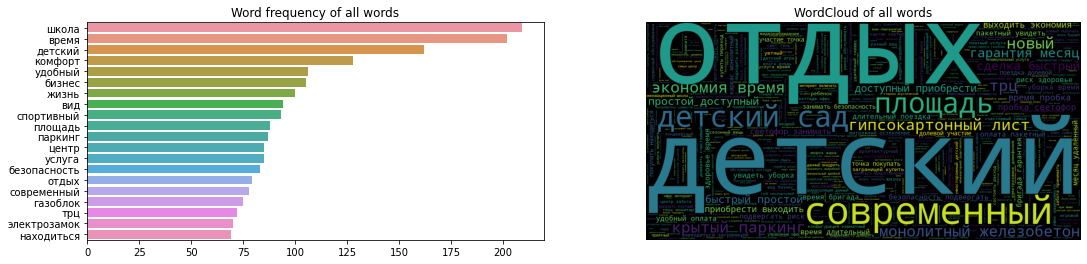

In [16]:
# Visualizations
def word_freq(tok, title):
    c = Counter(tok)
    most = c.most_common()
    x, y= [], []

    for word,count in most[:20]:
            x.append(word)
            y.append(count)
            
    ax[0].set_title(title)
    sns.barplot(x=y,y=x, ax=ax[0]);

def show_wordcloud(data, title):
    wordcloud = WordCloud(width = 1000, height = 500, max_words=1000)
    wordcloud=wordcloud.generate((" ").join(data))
    ax[1].imshow(wordcloud)
    ax[1].set_title(title)
    ax[1].axis("off")

fig, ax= plt.subplots(ncols=2,figsize=(18,4))
word_freq(filtered_tokens, 'Word frequency of all words')
show_wordcloud(filtered_tokens, 'WordCloud of all words')

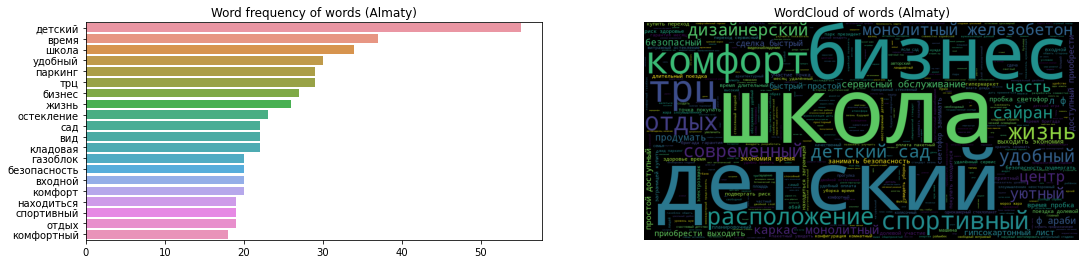

In [17]:
by_city = df.groupby('city', as_index=False)['text'].sum()
almaty_tokens = [morph.parse(i)[0].normal_form for i in (by_city[by_city.city=='almaty']['text']).values[0].split(' ')]
almaty_tokens = filter_tokens(almaty_tokens)

fig, ax= plt.subplots(ncols=2,figsize=(18,4))
word_freq(almaty_tokens, 'Word frequency of words (Almaty)')
show_wordcloud(almaty_tokens, 'WordCloud of words (Almaty)')

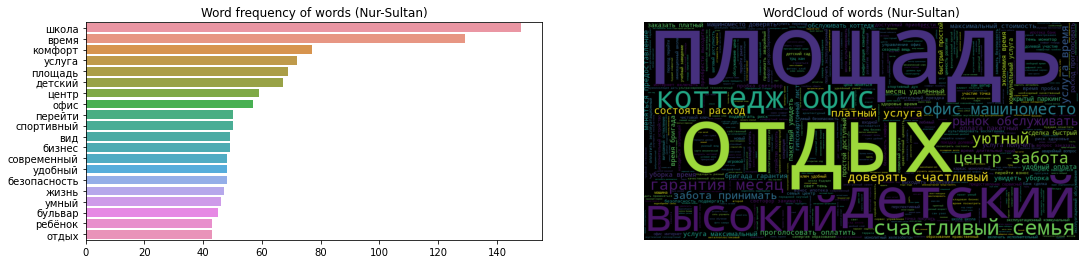

In [18]:
nur_tokens = [morph.parse(i)[0].normal_form for i in (by_city[by_city.city=='nur-sultan']['text']).values[0].split(' ')]
nur_tokens= filter_tokens(nur_tokens)

fig, ax= plt.subplots(ncols=2,figsize=(18,4))
word_freq(nur_tokens, 'Word frequency of words (Nur-Sultan)')
show_wordcloud(nur_tokens, 'WordCloud of words (Nur-Sultan)')

The visualizations above highlighted key words in the text, such as “Школа”, “детский сад”, “отдых”, “крытый паркинг”, “трц”, etc.

## 3. Search engine 

Our Search engine uses TF-IDF as part of ranking algorithms. All rankings revolve around keywords.

TF-IDF allows search engines to distinguish between important and unimportant words. Search engines may come across a keyword used dozens of times on a page, but if the keyword has a high inverse document frequency, they’ll deem it unimportant. Search engines can then process the page’s words more accurately to determine what the page as a whole is about.

TF(Term Frequency) - The number of times a word appears in a document divded by the total number of words in the document. Every document has its own term frequency.
$$ tf_{i,j} = \frac {n_{i,j}} {\sum n_{i,j}}$$
IDF (Inverse Data Frequency) - The log of the number of documents divided by the number of documents that contain the word w. IDF determines the weight of rare words across all documents in the corpus.
$$ idf(w) = log(\frac {N} {df_{t}})$$ 
TF-IDF is simply the TF multiplied by IDF.
$$   TF_-IDF = tf * idf $$ 

In [20]:
df2 = df.copy()
filtered_text =  []
for txt in df2.text:
    words = word_tokenize(txt, language="russian")
    norm_form  = [morph.parse(i)[0].normal_form for i in words]
    
    filtered_text.append(filter_tokens(norm_form ))
    
df2['filtered_text'] = [' '.join(i)for i in filtered_text]   

In [21]:
vectorizer = TfidfVectorizer()
tfidf_mat = vectorizer.fit_transform(df2.filtered_text.values)

During the query processing step, we use the cosine_similarity function to calculate the cosine similarity distances for the given query and all documents available in the text. The cosine similarities are then sorted in decreasing order.

The top five papers with the highest similarity scores are obtained in the last stage:

In [53]:
def get_recom(search, tfidf_mat=tfidf_mat):
    dff = df2.copy()
#   Tokenize words and remove stop words from input text
    words = word_tokenize(search, language="russian")
    norm_form  = [morph.parse(i)[0].normal_form for i in words] 
    search  = filter_tokens(norm_form)
    
#   Vectorize input text
    search_vector = vectorizer.transform(search)
     
#   Calculate cosine similarity scores
    mat = cosine_similarity(search_vector, tfidf_mat)
    cosine_sim = np.mean(mat, axis=0) 
    sim_scores = list(enumerate(cosine_sim))
    
#   Create new column for similarity scores
    dff['similarity'] = [i[1] for i in sim_scores]
    
#   Sort similarity scores in descending order
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

#   Find complex indexes  where similarity score more than 0
    idxs = [i[0] for i in sim_scores if i[1]>0]
    
#   Define the city
    if 'алматы' in norm_form:
        city = 'almaty'
    else:
        city = 'nur-sultan'
#     city = dff.iloc[idxs].city.mode()[0]
    idxs_ = [i[0] for i in sim_scores if ((i[1]>0) & (dff.iloc[i[0]].city==city))]
    
#   Return top 10 documents with the highest similarity scores  
    return dff.iloc[idxs_[:5]]

### Execute the query
Executing the query as the first search. Here the input of the search is: <i>"Я искал район Ботанического сада, район за Хан Шатыром до Жагалау, район до нового ж/д вокзала. ЖК преимущественно комфорт класса, с какой нибудь облицовкой, а не штукатуркой, 1-2 комнатная, выше 45 кв.м., не позднее 2018 года постройки, с двором без машин, с локацией - один детский сад, школа, парк погулять и автобусная остановка. Обычные.".</i>

In [51]:
get_recom(input())

Я искал район Ботанического сада, район за Хан Шатыром до Жагалау, район до нового ж/д вокзала. ЖК преимущественно комфорт класса, с какой нибудь облицовкой, а не штукатуркой, 1-2 комнатная, выше 45 кв.м., не позднее 2018 года постройки, с двором без машин, с локацией - один детский сад, школа, парк погулять и автобусная остановка. Обычные.


,complex,text,city,filtered_text,similarity
10,Capital Park,о проекте вернуться к содержанию связаться в ...,nur-sultan,бигвилль семейство дух уникальный концепция на...,0.029328
35,Sezim Qala.Senim,о проекте квартал комфорт-класса отвечает все...,nur-sultan,комфорт-класс отвечать потребность мегаполис я...,0.025039
36,Shabyt,о проекте жилой комплекс находится на улице о...,nur-sultan,находиться орынбора проспект туран кабанбай ба...,0.022824
17,GreenLine.FreeDom,о проекте проект в семействе кварталов бигвил...,nur-sultan,семейство бигвилля комфорт встречаться эстетик...,0.022387
34,Sezim Qala.Baqyt,о проекте квартал расположен на пересечении у...,nur-sultan,пересечение роза баглановый тол тихий создать ...,0.022363


Another search with the query of <i>"Школа binom".</i>

In [52]:
get_recom(input())

Школа binom


,complex,text,city,filtered_text,similarity
35,Sezim Qala.Senim,о проекте квартал комфорт-класса отвечает все...,nur-sultan,комфорт-класс отвечать потребность мегаполис я...,0.130461
16,GreenLine.Aura,о проекте проект бизнес-класса расположенный ...,nur-sultan,бизнес-класс пересечение еки екв шаговый близо...,0.123153
34,Sezim Qala.Baqyt,о проекте квартал расположен на пересечении у...,nur-sultan,пересечение роза баглановый тол тихий создать ...,0.118529
17,GreenLine.FreeDom,о проекте проект в семействе кварталов бигвил...,nur-sultan,семейство бигвилля комфорт встречаться эстетик...,0.116642
29,Nova City на Туране,о проекте на туране современный жилой комплек...,nur-sultan,туран современный проспект ран рядом строиться...,0.114932


Another search with the query of <i>"красивый фасад"</i>.

In [33]:
get_recom(input())

красивый фасад


,complex,text,city,filtered_text,similarity
8,Atlant,о проекте это современный жилой квартал котор...,nur-sultan,современный перенести самый центр левый берег ...,0.048694
42,Поколение,о проекте поколение бигвилль с развитой инфра...,nur-sultan,поколение бигвилль развитой инфраструктура сос...,0.047959
15,GreenLine.Aqua,о проекте это квартал бизнес класса являющийс...,nur-sultan,бизнес являться продолжение идейно-тематически...,0.043789


Another search with the query of <i>"Алматы"</i>.

In [54]:
get_recom(input())

Алматы


,complex,text,city,filtered_text,similarity
33,Riverside,о проекте это современный комфортный стильный...,almaty,современный комфортный удачно хороший традиция...,0.140980
31,O'NER,о проекте жилой комплекс вдохновленный культу...,almaty,вдохновить культурный жизнь удачный расположен...,0.132611
38,Taugul,о проекте жилой комплекс это яркий и красочны...,almaty,яркий красочный цветок фон привычный застройка...,0.099759
6,AMIR,о проекте жк это проект бизнес и бизнес класс...,almaty,бизнес бизнес встроить стоящий разный этажност...,0.089561
24,Lake Town,о проекте жилой комплекс расположен в тихом и...,almaty,тихий спокойный локация привлекательный делово...,0.053453


Another search with the query of <i>"больница"</i>.

In [43]:
get_recom(input())

больница


,complex,text,city,filtered_text,similarity
26,NEXPO CITY,о проекте в нур-султане возводит многообразны...,nur-sultan,нур-султан возводить многообразный кластер кон...,0.317878
28,Nexpo Union,о бигвилле бигвилль это жизнь на страницах де...,nur-sultan,бигвилле бигвилль жизнь страница деловой культ...,0.180153
27,Nexpo Classic,о проекте бигвилль это жизнь на страницах дел...,nur-sultan,бигвилль жизнь страница деловой культурный ист...,0.109638


Another search with the query of <i>"уютный жк комфорт класса"</i>.

In [46]:
get_recom(input())

уютный жк комфорт класса


,complex,text,city,filtered_text,similarity
35,Sezim Qala.Senim,о проекте квартал комфорт-класса отвечает все...,nur-sultan,комфорт-класс отвечать потребность мегаполис я...,0.087467
17,GreenLine.FreeDom,о проекте проект в семействе кварталов бигвил...,nur-sultan,семейство бигвилля комфорт встречаться эстетик...,0.071650
23,Jetisu.Lepsi,о проекте первый квартал на территории которы...,nur-sultan,назвать честь река входящий состав вдоль просп...,0.071219
19,GreenLine.Terra,о проекте проект комфорт-класса расположенный...,nur-sultan,комфорт-класс вдоль мухамедханов семейство объ...,0.070114
10,Capital Park,о проекте вернуться к содержанию связаться в ...,nur-sultan,бигвилль семейство дух уникальный концепция на...,0.069716
